In [1]:
import sys
sys.path.append('../')
from __future__ import print_function
import pdb
from PIL import Image
import matplotlib.pyplot as plt
import sys
import random
import os
import argparse
import torch
import pandas as pd
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.autograd import Variable
from data.dataloader import DATA_ROOT
from data.transform import BaseTransform
from PIL import Image
from ssd import *
import torch.utils.data as data
from data.dataloader import provider
from submission import *

%matplotlib inline

HOME: /home/eee/ug/15084015/kaggle/rsna-pneumonia-detection-challenge
DATA_ROOT:  /home/eee/ug/15084015/kaggle/rsna-pneumonia-detection-challenge/data


In [2]:
cuda=True
if cuda and torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')
visual_threshold = 0.6
device = torch.device("cuda:0" if cuda else "cpu")

trained_model_path = '../weights/model.pth'

In [3]:
# load net
num_classes = len(CLASSES) + 1 # +1 background
net = build_ssd('test', 300, num_classes) # initialize SSD
net = torch.nn.DataParallel(net)

In [4]:
# if not cuda:
#     net.load_state_dict(torch.load(trained_model_path,  map_location=lambda storage, loc: storage)['state'])
# else:
net.load_state_dict(torch.load(trained_model_path)['state_dict'])
net = net.to(device)
net.eval();

## Analyse the model on dataloader

In [5]:
dataloader = provider(phase='val', batch_size=8)

In [6]:
fnames, images, boxes = next(iter(dataloader))
images = images.to(device)
pred = net(images)
detections = pred.data
iter_range = iter(range(len(images)))

In [7]:
for i, box in enumerate(boxes):
    print(i, box)

0 tensor([[ 0.,  0.,  0.,  0., -1.]], device='cpu')
1 tensor([[ 0.,  0.,  0.,  0., -1.]], device='cpu')
2 tensor([[0.2734, 0.4473, 0.4004, 0.5762, 0.0000],
        [0.6133, 0.3232, 0.7070, 0.4619, 0.0000]], device='cpu')
3 tensor([[ 0.,  0.,  0.,  0., -1.]], device='cpu')
4 tensor([[ 0.,  0.,  0.,  0., -1.]], device='cpu')
5 tensor([[ 0.,  0.,  0.,  0., -1.]], device='cpu')
6 tensor([[ 0.,  0.,  0.,  0., -1.]], device='cpu')
7 tensor([[ 0.,  0.,  0.,  0., -1.]], device='cpu')


In [8]:
for i in range(len(images)):
    print(i, detections[i, 1, :9, 0])

0 tensor([0.3192, 0.3105, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
1 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
2 tensor([0.2896, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
3 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
4 tensor([0.2822, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
5 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
6 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
7 tensor([0.2452, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


0 tensor([0.3192, 0.3105, 0.0000, 0.0000, 0.0000])


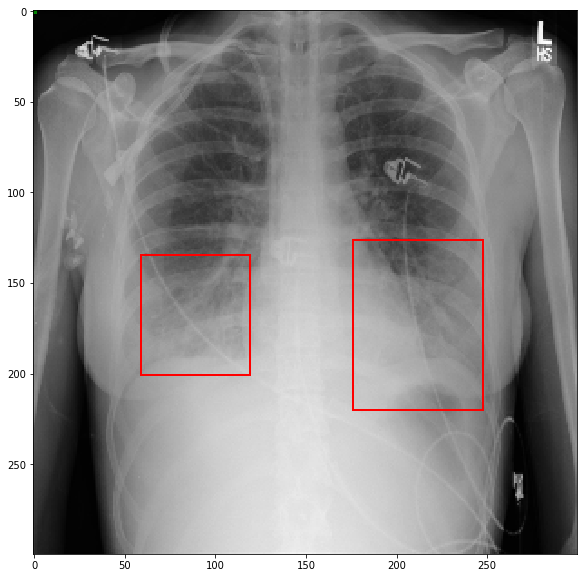

In [9]:
'''Plot random test images with trained SSD's predictions'''
# iter_range = iter(range(len(images)))
# i = random.choice(list(range(len(images))))
i = next(iter_range)
# i=7
print(i, detections[i, 1, :5, 0])
fig, ax = plt.subplots(figsize=(10, 10))
for box in boxes[i]:
    box = [i* 300 for i in box]
    XMin, YMin, XMax, YMax = box[0], box[1], box[2], box[3]
    w = XMax - XMin + 1
    h = YMax - YMin + 1
    rect = plt.Rectangle((XMin, YMin), width=w, height=h, edgecolor='g', fill=None, linewidth=2)
    ax.add_patch(rect)

scale = torch.Tensor([300] * 4)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

for idx in np.where(detections[i, 1, :, 0] >= 0.2)[0]:
    score = detections[i, 1, idx, 0]
    XMin, YMin, XMax, YMax = [x * 300 for x in detections[i, 1, idx, 1:]]
    w = XMax - XMin + 1
    h = YMax - YMin + 1
    rect = plt.Rectangle((XMin, YMin), width=w, height=h, edgecolor='r', fill=None, linewidth=2)
    ax.add_patch(rect)

ax.imshow(images.data[i][0] * 255, cmap="gist_gray")
plt.show();

## Analyse on test set

In [ ]:
# load data
root = "data/stage_1_train_images/"
sample_submission_path =  "data/stage_1_sample_submission.csv"
testset = TestDataset(
    root,
    sample_submission_path,
)

if cuda:
    net = net.cuda()
    cudnn.benchmark = True
# evaluation
transform = BaseTransform(net.size, (104, 117, 123))
num_images = len(testset)


In [ ]:
'''Plot random test images with trained SSD's predictions'''
i = random.choice(list(range(num_images)))
img = testset.pull_image(i)
x = torch.from_numpy(transform(img)[0]).permute(2, 0, 1)
x = Variable(x.unsqueeze(0))
if cuda:
    x = x.cuda()
y = net(x)      # forward pass
detections = y.data
# scale each detection back up to the image
scale = torch.Tensor([img.shape[1], img.shape[0],
                     img.shape[1], img.shape[0]])

fig,ax = plt.subplots(figsize=(10, 10))
image = Image.open('../data/image_data/' + testset.fnames[i])
j = 0
while detections[0, 1, j, 0] >= 0.2:
    score = detections[0, 1, j, 0]
    label_name = labelmap[0]
    pt = (detections[0, 1, j, 1:] * scale).cpu().numpy()
    coords = (pt[0], pt[1], pt[2], pt[3])
    XMin, YMin, XMax, YMax = coords
    w = XMax - XMin + 1
    h = YMax - YMin + 1
    rect = plt.Rectangle((XMin, YMin), width=w, height=h, edgecolor='r', fill=None, linewidth=2)
    ax.add_patch(rect)
    j += 1

ax.imshow(image)
plt.show()

In [ ]:

fig,ax = plt.subplots(figsize=(10, 10))
image = Image.open('../data/image_data/' + testset.fnames[i])
j = 0
while detections[0, 1, j, 0] >= 0.2:
    score = detections[0, 1, j, 0]
    label_name = labelmap[0]
    pt = (detections[0, 1, j, 1:] * scale).cpu().numpy()
    coords = (pt[0], pt[1], pt[2], pt[3])
    XMin, YMin, XMax, YMax = coords
    w = XMax - XMin + 1
    h = YMax - YMin + 1
    rect = plt.Rectangle((XMin, YMin), width=w, height=h, edgecolor='r', fill=None, linewidth=2)
    ax.add_patch(rect)
    j += 1

ax.imshow(image)
plt.show()

## FUCKERY:
i = 387, nms=0.01 completely misses out the other beautiful girl :(, set the fucking nms threshold to 0.4 or 0.45 :/

In [ ]:
# load data
root = "../data/image_data/"
train_csv = "../data/train.csv"
trainset = TestDataset(
    root,
    train_csv,
)
df = pd.read_csv(train_csv)

In [ ]:
'''Plot random train images with trained SSD's predictions and ground truth headcount'''
i = random.choice(list(range(len(trainset))))
i=2493
img = trainset.pull_image(i)
x = torch.from_numpy(transform(img)[0]).permute(2, 0, 1)
x = Variable(x.unsqueeze(0))
if cuda:
    x = x.cuda()
y = net(x)      # forward pass
detections = y.data
# scale each detection back up to the image
scale = torch.Tensor([img.shape[1], img.shape[0],
                     img.shape[1], img.shape[0]])

fig,ax = plt.subplots(figsize=(10, 10))

visual_threshold = 0.3
print('HeadCount=> Ground :', df.iloc[i]['HeadCount'], 
      '\nPredicted (0.5): ', sum(detections[0][1][:, 0] >= 0.5),
     '\nPredicted (0.4): ', sum(detections[0][1][:, 0] >= 0.4),
     '\nPredicted (0.3): ', sum(detections[0][1][:, 0] >= 0.3),
     '\nPredicted (0.2): ', sum(detections[0][1][:, 0] >= 0.2),
     '\nPredicted (0.1): ', sum(detections[0][1][:, 0] >= 0.1),
     )
     
image = Image.open('../data/image_data/' + trainset.fnames[i])
j = 0
while detections[0, 1, j, 0] >= 0.1:
    score = detections[0, 1, j, 0]
    label_name = labelmap[0]
    pt = (detections[0, 1, j, 1:] * scale).cpu().numpy()
    coords = (pt[0], pt[1], pt[2], pt[3])
    XMin, YMin, XMax, YMax = coords
    w = XMax - XMin + 1
    h = YMax - YMin + 1
    rect = plt.Rectangle((XMin, YMin), width=w, height=h, edgecolor='r', fill=None, linewidth=2)
    ax.add_patch(rect)
    j += 1

ax.imshow(image)
plt.show()

In [ ]:
i

In [ ]:
fig,ax = plt.subplots(figsize=(10, 10))

j = 0
while detections[0, 1, j, 0] >= 0.1:
    score = detections[0, 1, j, 0]
    label_name = labelmap[0]
    pt = (detections[0, 1, j, 1:] * scale).cpu().numpy()
    coords = (pt[0], pt[1], pt[2], pt[3])
    XMin, YMin, XMax, YMax = coords
    w = XMax - XMin + 1
    h = YMax - YMin + 1
    rect = plt.Rectangle((XMin, YMin), width=w, height=h, edgecolor='r', fill=None, linewidth=2)
    ax.add_patch(rect)
    j += 1

ax.imshow(image)
plt.show()